In [3]:
import sys
!{sys.executable} -m pip install matplotlib


   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   -------- ------------------------------- 1.8/8.3 MB 9.2 MB/s eta 0:00:01
   --------------------- ------------------ 4.5/8.3 MB 13.6 MB/s eta 0:00:01
   ---------------------------------------  8.1/8.3 MB 13.2 MB/s eta 0:00:01
   ---------------------------------------- 8.3/8.3 MB 12.4 MB/s  0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 12.3 MB/s  0:00:00
   ---------------------------------------- 0.0/7.2 MB ? eta -:--:--
   ---------------- ----------------------- 2.9/7.2 MB 13.4 MB/s eta 0:00:01
   ------------------------------ --------- 5.5/7.2 MB 13.3 MB/s eta 0:00:01
   ---------------------------------------  7.1/7.2 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------- 7.2/7.2 MB 10.6 MB/s  0:00:00

   ---------------------------------------- 0/7 [pyparsing]
   ----- ---------------------------------- 1/7 [

In [4]:
"""
Breast Cancer Prediction with KNN
Author: [Anson Knausenberger]
Description: Predict whether a breast tumor is malignant or benign using KNN
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

# Load the breast cancer dataset
print("Loading breast cancer dataset...")
cancer_data = load_breast_cancer()

# The dataset is a Bunch object with 'data', 'target', 'feature_names', etc.
print(f"\nDataset type: {type(cancer_data)}")
print(f"Number of samples: {len(cancer_data.data)}")
print(f"Number of features: {len(cancer_data.feature_names)}")
print(f"Target classes: {cancer_data.target_names}")

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
df['target'] = cancer_data.target

print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nTarget distribution:")
print(df['target'].value_counts())
print(f"Malignant (0): {(df['target'] == 0).sum()}")
print(f"Benign (1): {(df['target'] == 1).sum()}")


Loading breast cancer dataset...

Dataset type: <class 'sklearn.utils._bunch.Bunch'>
Number of samples: 569
Number of features: 30
Target classes: ['malignant' 'benign']

First few rows:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520

### Step 1 Observations
- The breast cancer dataset loaded successfully as a sklearn Bunch object with 569 samples and 30 numeric features.
- I converted the feature data into a pandas DataFrame and added the target column for easier inspection.
- The dataset has two classes: malignant and benign, with target values 0 = malignant (212) and 1 = benign (357), so it’s slightly imbalanced.



BASIC STATISTICS
       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.0

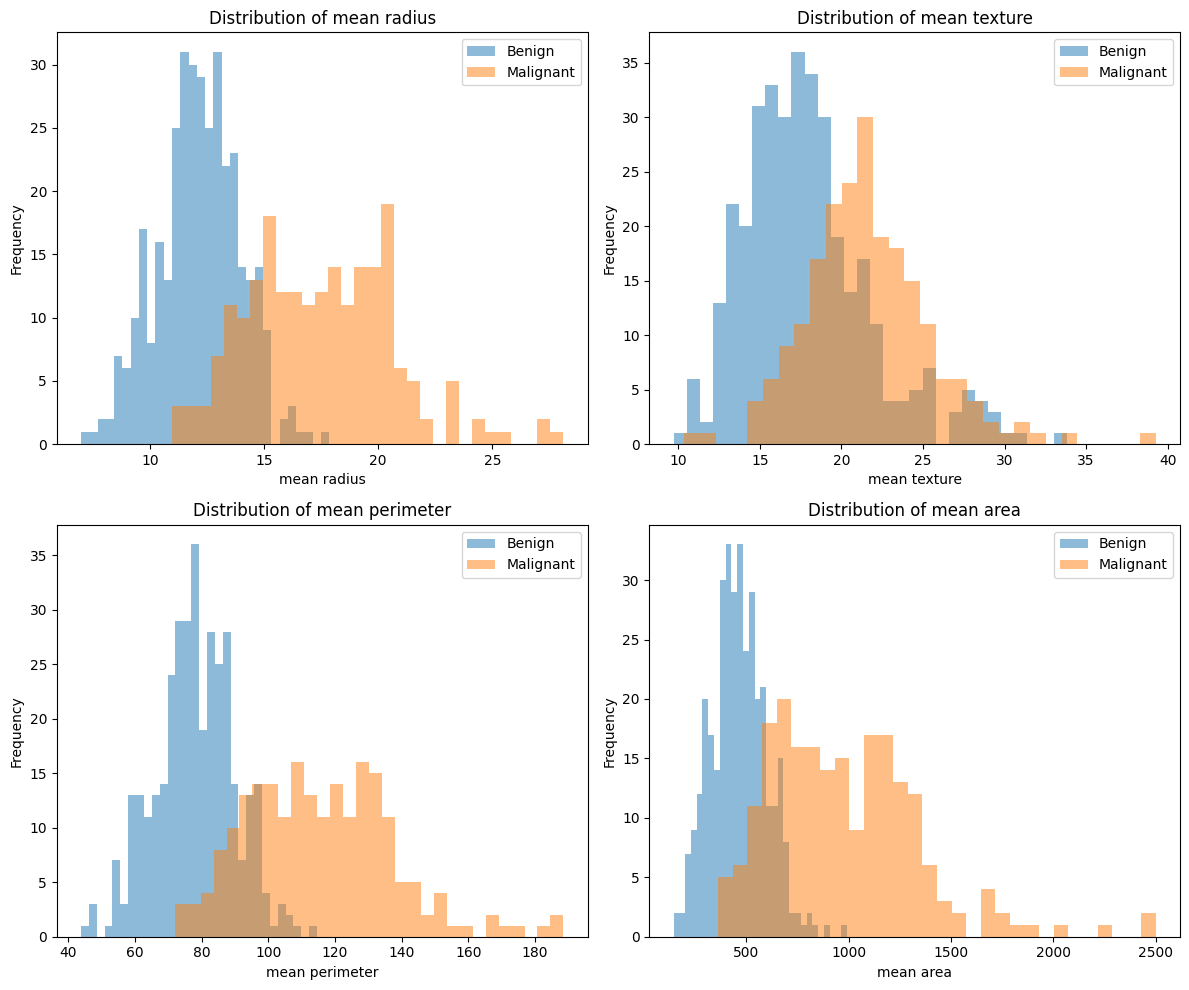

In [5]:
# Basic statistics
print("\n" + "="*50)
print("BASIC STATISTICS")
print("="*50)
print(df.describe())

# Check for missing values
print("\n" + "="*50)
print("MISSING VALUES")
print("="*50)
missing = df.isnull().sum()
if missing.sum() == 0:
    print("✓ No missing values found!")
else:
    print(missing[missing > 0])

# Visualize feature distributions (select a few key features)
print("\n" + "="*50)
print("FEATURE DISTRIBUTIONS")
print("="*50)

# Select a few representative features to visualize
key_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    # 0 = malignant, 1 = benign
    axes[idx].hist(df[df['target'] == 1][feature], alpha=0.5, label='Benign', bins=30)
    axes[idx].hist(df[df['target'] == 0][feature], alpha=0.5, label='Malignant', bins=30)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Distribution of {feature}')
    axes[idx].legend()

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=150, bbox_inches='tight')
print("Saved visualization to 'feature_distributions.png'")
plt.show()


### Step 2 Observations
- `df.describe()` shows all 30 features are numeric and on different scales (some features like area/perimeter have much larger ranges than others).
- There are no missing values in the dataset.
- The histograms show clear separation: malignant tumors generally have larger values for mean radius, mean perimeter, and mean area than benign tumors (texture overlaps more).

In [6]:
# Separate features and target
X = df.drop('target', axis=1)  # All columns except 'target'
y = df['target']  # Target column

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split into training and testing sets
# random_state ensures reproducibility
# stratify=y ensures both sets have similar class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("\n" + "="*50)
print("DATA SPLIT")
print("="*50)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Training features: {X_train.shape[1]}")
print(f"Test features: {X_test.shape[1]}")

# Verify class distribution in both sets
print("\nTraining set target distribution:")
print(y_train.value_counts())
print(f"  Malignant (0): {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"  Benign (1): {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")

print("\nTest set target distribution:")
print(y_test.value_counts())
print(f"  Malignant (0): {(y_test == 0).sum()} ({(y_test == 0).mean()*100:.1f}%)")
print(f"  Benign (1): {(y_test == 1).sum()} ({(y_test == 1).mean()*100:.1f}%)")


Features shape: (569, 30)
Target shape: (569,)

DATA SPLIT
Training set size: 455 samples
Test set size: 114 samples
Training features: 30
Test features: 30

Training set target distribution:
target
1    285
0    170
Name: count, dtype: int64
  Malignant (0): 170 (37.4%)
  Benign (1): 285 (62.6%)

Test set target distribution:
target
1    72
0    42
Name: count, dtype: int64
  Malignant (0): 42 (36.8%)
  Benign (1): 72 (63.2%)


### Step 3 Observations
- I separated the dataset into features `X` (30 columns) and target `y` (569 labels).
- I split the data into 455 training samples (80%) and 114 test samples (20%) using `random_state=42` for reproducibility.
- Using `stratify=y` kept the malignant/benign proportions nearly the same in both train and test sets.


In [7]:
# Create KNN classifier
# n_neighbors=5 means the model will look at the 5 nearest neighbors to make a prediction

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

print("KNN classifier trained successfully!")
print(f"Number of neighbors (k): {knn.n_neighbors}")

# Make predictions
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

print(f"\nTraining predictions: {len(y_train_pred)}")
print(f"Test predictions: {len(y_test_pred)}")


KNN classifier trained successfully!
Number of neighbors (k): 5

Training predictions: 455
Test predictions: 114


### Step 4 Observations
- I trained a K-Nearest Neighbors (KNN) classifier with k = 5 using the training dataset.
- KNN predicts a new sample by finding the 5 most similar (closest) training samples and choosing the most common class among them.
- The model produced predictions for all 455 training samples and 114 test samples without errors.


In [8]:
print("\n" + "="*50)
print("STEP 5: PREDICTIONS vs ACTUAL")
print("="*50)

# Make predictions on the test set (you already created y_test_pred in Step 4,
# but this re-runs it safely in case cells were run out of order)
y_test_pred = knn.predict(X_test)

# Show first 15 predictions vs actual
comparison_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_test_pred
})

# Map 0/1 to readable labels (remember: 0 = malignant, 1 = benign)
label_map = {0: "malignant", 1: "benign"}
comparison_df["Actual_label"] = comparison_df["Actual"].map(label_map)
comparison_df["Predicted_label"] = comparison_df["Predicted"].map(label_map)

print("\nFirst 15 predictions vs actual:")
print(comparison_df.head(15))

# Count how many are correct in these 15
correct_15 = (comparison_df["Actual"] == comparison_df["Predicted"]).head(15).sum()
print(f"\nCorrect in first 15 examples: {correct_15}/15")

# Show a few mismatches (if any)
mismatches = comparison_df[comparison_df["Actual"] != comparison_df["Predicted"]]
print(f"\nTotal mismatches in test set: {len(mismatches)}")

print("\nFirst 10 mismatches (if they exist):")
print(mismatches.head(10))



STEP 5: PREDICTIONS vs ACTUAL

First 15 predictions vs actual:
    Actual  Predicted Actual_label Predicted_label
0        0          0    malignant       malignant
1        1          1       benign          benign
2        0          0    malignant       malignant
3        1          0       benign       malignant
4        0          0    malignant       malignant
5        1          1       benign          benign
6        1          1       benign          benign
7        0          0    malignant       malignant
8        0          0    malignant       malignant
9        0          0    malignant       malignant
10       1          1       benign          benign
11       0          0    malignant       malignant
12       1          1       benign          benign
13       0          0    malignant       malignant
14       0          0    malignant       malignant

Correct in first 15 examples: 14/15

Total mismatches in test set: 10

First 10 mismatches (if they exist):
     Actual

### Step 5 Observations
- The model successfully generated predictions for every sample in the test set.
- In the first 15 test examples, 14 predictions matched the actual label.
- There were 10 total mismatches in the full test set, which we’ll quantify more formally using evaluation metrics next.


In [9]:
# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# For this dataset: 0 = malignant, 1 = benign
# We want malignant to be the "positive" class for precision/recall, so set pos_label=0
test_precision_malignant = precision_score(y_test, y_test_pred, pos_label=0)
test_recall_malignant = recall_score(y_test, y_test_pred, pos_label=0)

test_confusion = confusion_matrix(y_test, y_test_pred)

print("=== Model Performance ===")
print(f"\nTraining Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print("\n(Considering MALIGNANT as the positive class: target=0)")
print(f"Test Precision (malignant): {test_precision_malignant:.4f}")
print(f"Test Recall (malignant):    {test_recall_malignant:.4f}")

print("\n=== Confusion Matrix (rows=Actual, cols=Predicted) ===")
print("Order: 0=malignant, 1=benign")
print(test_confusion)

tn, fp, fn, tp = test_confusion.ravel()  # for 0/1 this is: [[TN, FP],[FN, TP]] if positive=1
# But since our "positive" is 0, interpret manually:
# Matrix is:
# actual 0 predicted 0 = correct malignant
# actual 0 predicted 1 = missed malignant (dangerous)
# actual 1 predicted 0 = benign flagged as malignant
# actual 1 predicted 1 = correct benign

print("\nInterpretation:")
print(f"Correct malignant (actual 0 → predicted 0): {test_confusion[0,0]}")
print(f"Missed malignant  (actual 0 → predicted 1): {test_confusion[0,1]}")
print(f"Benign flagged malignant (actual 1 → predicted 0): {test_confusion[1,0]}")
print(f"Correct benign    (actual 1 → predicted 1): {test_confusion[1,1]}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_test_pred, target_names=cancer_data.target_names))


=== Model Performance ===

Training Accuracy: 0.9473 (94.73%)
Test Accuracy: 0.9123 (91.23%)

(Considering MALIGNANT as the positive class: target=0)
Test Precision (malignant): 0.8636
Test Recall (malignant):    0.9048

=== Confusion Matrix (rows=Actual, cols=Predicted) ===
Order: 0=malignant, 1=benign
[[38  4]
 [ 6 66]]

Interpretation:
Correct malignant (actual 0 → predicted 0): 38
Missed malignant  (actual 0 → predicted 1): 4
Benign flagged malignant (actual 1 → predicted 0): 6
Correct benign    (actual 1 → predicted 1): 66

=== Classification Report ===
              precision    recall  f1-score   support

   malignant       0.86      0.90      0.88        42
      benign       0.94      0.92      0.93        72

    accuracy                           0.91       114
   macro avg       0.90      0.91      0.91       114
weighted avg       0.91      0.91      0.91       114



### Step 6 Observations
- The model achieved 94.73% training accuracy and 91.23% test accuracy, which suggests decent generalization with some errors on unseen data.
- Treating malignant as the “positive” class (target = 0), precision is 0.86 and recall is 0.90, meaning it correctly identifies most malignant cases but still misses some.
- The confusion matrix shows 4 missed malignant cases (malignant predicted as benign) and 6 false alarms (benign predicted as malignant); missed malignant cases are the most concerning in a medical screening context.



EXPERIMENTING WITH DIFFERENT K VALUES
K= 1: Accuracy=0.9211, Precision(malig)=0.8667, Recall(malig)=0.9286
K= 3: Accuracy=0.9298, Precision(malig)=0.9048, Recall(malig)=0.9048
K= 5: Accuracy=0.9123, Precision(malig)=0.8636, Recall(malig)=0.9048
K= 7: Accuracy=0.9298, Precision(malig)=0.9048, Recall(malig)=0.9048
K= 9: Accuracy=0.9386, Precision(malig)=0.9268, Recall(malig)=0.9048
K=11: Accuracy=0.9386, Precision(malig)=0.9268, Recall(malig)=0.9048

Best K value by Accuracy: 9 (Accuracy: 0.9386)

Saved visualization to 'knn_k_comparison.png'


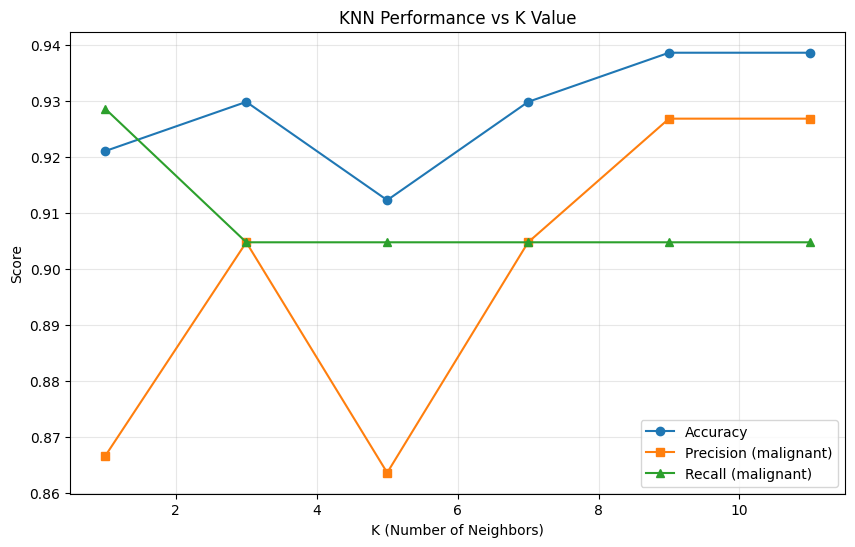

,K,Accuracy,Precision_malignant,Recall_malignant
0,1,0.921053,0.866667,0.928571
1,3,0.929825,0.904762,0.904762
2,5,0.912281,0.863636,0.904762
3,7,0.929825,0.904762,0.904762
4,9,0.938596,0.926829,0.904762
5,11,0.938596,0.926829,0.904762


In [10]:
# Experiment with different K values
print("\n" + "="*50)
print("EXPERIMENTING WITH DIFFERENT K VALUES")
print("="*50)

k_values = [1, 3, 5, 7, 9, 11]
results = []

for k in k_values:
    # Create and train model
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train, y_train)

    # Make predictions
    y_pred_temp = knn_temp.predict(X_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred_temp)

    # malignant is class 0 in this dataset, so treat it as "positive"
    prec_malig = precision_score(y_test, y_pred_temp, pos_label=0)
    rec_malig = recall_score(y_test, y_pred_temp, pos_label=0)

    results.append({
        'K': k,
        'Accuracy': acc,
        'Precision_malignant': prec_malig,
        'Recall_malignant': rec_malig
    })

    print(f"K={k:2d}: Accuracy={acc:.4f}, Precision(malig)={prec_malig:.4f}, Recall(malig)={rec_malig:.4f}")

# Find best K by accuracy (simple approach)
results_df = pd.DataFrame(results)
best_k = results_df.loc[results_df['Accuracy'].idxmax(), 'K']
print(f"\nBest K value by Accuracy: {best_k} (Accuracy: {results_df['Accuracy'].max():.4f})")

# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(results_df['K'], results_df['Accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['K'], results_df['Precision_malignant'], marker='s', label='Precision (malignant)')
plt.plot(results_df['K'], results_df['Recall_malignant'], marker='^', label='Recall (malignant)')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Score')
plt.title('KNN Performance vs K Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('knn_k_comparison.png', dpi=150, bbox_inches='tight')
print("\nSaved visualization to 'knn_k_comparison.png'")
plt.show()

results_df


### Step 7 Observations
- Changing K changes performance: smaller K can be more sensitive (higher recall) but may create more false alarms, while larger K smooths decisions and can improve stability.
- In my results, K=9 (and K=11) achieved the highest test accuracy (~0.939) and the highest precision for malignant (~0.927), while recall for malignant stayed ~0.905.
- If the priority is to catch as many malignant cases as possible, K=1 had the highest malignant recall (~0.929), but with lower precision (more false positives).
